# Step 1: Import Necessary Libraries


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support
import matplotlib.pyplot as plt
import numpy as np
import torchvision.transforms as tt
import os
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader


# Step 2: Data Loading

In [2]:
train_tfms = tt.Compose([tt.ToTensor()])
valid_tfms = tt.Compose([tt.ToTensor()])

In [3]:
# Load train, validation and test dataset
data_dir = os.getcwd()
print("data_dir", data_dir)
train_file = os.path.join(data_dir, "train")
print("train_file", train_file)
val_file = os.path.join(data_dir, "validation")
print("val_file", val_file)
test_file = os.path.join(data_dir, "test")
print("test_file", test_file)

data_dir C:\Users\etson\PycharmProjects\pythonProject
train_file C:\Users\etson\PycharmProjects\pythonProject\train
val_file C:\Users\etson\PycharmProjects\pythonProject\validation
test_file C:\Users\etson\PycharmProjects\pythonProject\test


In [4]:
train_ds = ImageFolder(train_file, train_tfms)
val_ds = ImageFolder(val_file, valid_tfms)
test_ds = ImageFolder(test_file, valid_tfms)


In [5]:
# Batch Size
batch_size = 1000


In [6]:
# PyTorch data loaders
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size, num_workers=3, pin_memory=True)
test_dl = DataLoader(test_ds, batch_size, num_workers=3, pin_memory=True)


# Step 3: Define the Logistic Regression Model


In [7]:
class LogisticRegression(nn.Module):
    def __init__(self, input_size):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(input_size, 1)
    
    def forward(self, x):
        x = x.view(-1, input_size)  # Flatten the image
        out = self.linear(x)
        return out
        # return torch.sigmoid(out)


# Step 4: Initialize Model, Loss Function, and Optimizer


In [8]:
input_size = 50*50*3  # Flattened size of images
model = LogisticRegression(input_size)

train_positive_samples = 57089
train_negative_samples = 144435
pos_weight = torch.tensor([train_negative_samples / train_positive_samples])

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = optim.Adam(model.parameters())

# criterion = nn.BCELoss()
#optimizer = optim.SGD(model.parameters(), lr=0.01)


# Step 5: Train the Model with Validation


In [10]:
epochs = 10
for epoch in range(epochs):
    model.train()
    for images, labels in train_dl:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels.view(-1, 1).float())
        loss.backward()
        optimizer.step()
    
    # Validation phase
    model.eval()
    val_loss = 0
    val_steps = 0
    for images, labels in val_dl:
        with torch.no_grad():
            outputs = model(images)
            loss = criterion(outputs, labels.view(-1, 1).float())
            val_loss += loss.item()
            val_steps += 1
    avg_val_loss = val_loss / val_steps
    print(f'Epoch {epoch+1}/{epochs}, Training Loss: {loss.item()}, Validation Loss: {avg_val_loss}')
    

Epoch 1/10, Training Loss: 1.1859937906265259, Validation Loss: 0.7618248211710077
Epoch 2/10, Training Loss: 1.056484580039978, Validation Loss: 0.7270690673275998
Epoch 3/10, Training Loss: 1.0690809488296509, Validation Loss: 0.718762899699964
Epoch 4/10, Training Loss: 1.0789527893066406, Validation Loss: 0.7160145154124812
Epoch 5/10, Training Loss: 1.259397268295288, Validation Loss: 0.7113479328782935
Epoch 6/10, Training Loss: 1.3975378274917603, Validation Loss: 0.715805208212451
Epoch 7/10, Training Loss: 1.7112360000610352, Validation Loss: 0.7440058173317659
Epoch 8/10, Training Loss: 1.2187854051589966, Validation Loss: 0.7100032528764323
Epoch 9/10, Training Loss: 1.1737138032913208, Validation Loss: 0.710220112612373
Epoch 10/10, Training Loss: 1.3513480424880981, Validation Loss: 0.712683296517322


# Step 6: Final Evaluation on Test Set


In [12]:
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in test_dl:
        outputs = model(images)
        outputs = torch.sigmoid(outputs)
        predicted = torch.round(outputs)
        y_true.extend(labels.view(-1).tolist())
        y_pred.extend(predicted.view(-1).tolist())

precision, recall, f1_score, _ = precision_recall_fscore_support(y_true, y_pred, average='binary')
print(f'Precision: {precision}, Recall: {recall}, F1 Score: {f1_score}')


Precision: 0.6332052781025556, Recall: 0.7016472330186934, F1 Score: 0.6656716417910448


# Step 7: Visualize the Results


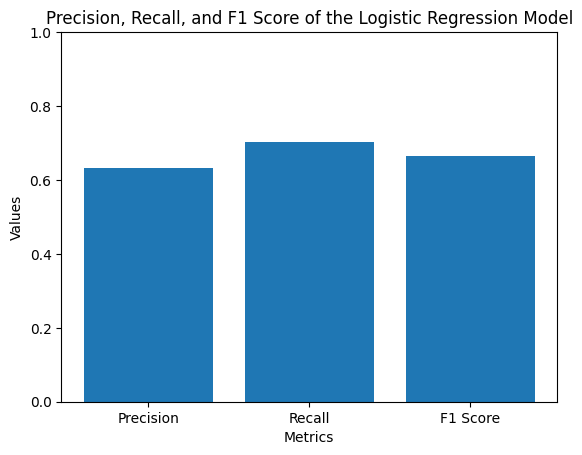

In [13]:
metrics = [precision, recall, f1_score]
metric_names = ['Precision', 'Recall', 'F1 Score']

plt.bar(metric_names, metrics)
plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('Precision, Recall, and F1 Score of the Logistic Regression Model')
plt.ylim(0, 1)
plt.show()
